In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_annotations(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    bboxes = []
    for obj in objects:
        bbox = obj.find('bndbox')
        # bboxes.append(
        bboxes.append(int(bbox.find('xmin').text))
        bboxes.append(int(bbox.find('ymin').text))
        bboxes.append(int(bbox.find('xmax').text))
        bboxes.append(int(bbox.find('ymax').text))
    return bboxes

def get_data(image_dir,annotation_dir,class_file):
    images = []
    bboxes = []
    labels = []
    with open(class_file, 'r') as f:
        for line in f:
            if line[0] != "#":
                parts = line.strip().split()
                image_name = parts[0] + '.jpg'
                class_id = int(parts[2])
                annotation_path = os.path.join(annotation_dir, parts[0] + '.xml')
                image_path = os.path.join(image_dir, image_name)
                if os.path.exists(image_path) and os.path.exists(annotation_path):
                    bbox = load_annotations(annotation_path)
                    images.append(image_path)
                    bboxes.append(bbox)
                    labels.append(class_id)
    return images,labels,bboxes

image_dir = 'C:/Users/Dell/Downloads/oxford-iiit-pet/images/images'
annotation_dir = 'C:/Users/Dell/Downloads/oxford-iiit-pet/annotations/annotations/xmls'
class_file = 'C:/Users/Dell/Downloads/oxford-iiit-pet/annotations/annotations/list.txt'

images, labels, bboxes = get_data(image_dir, annotation_dir, class_file)

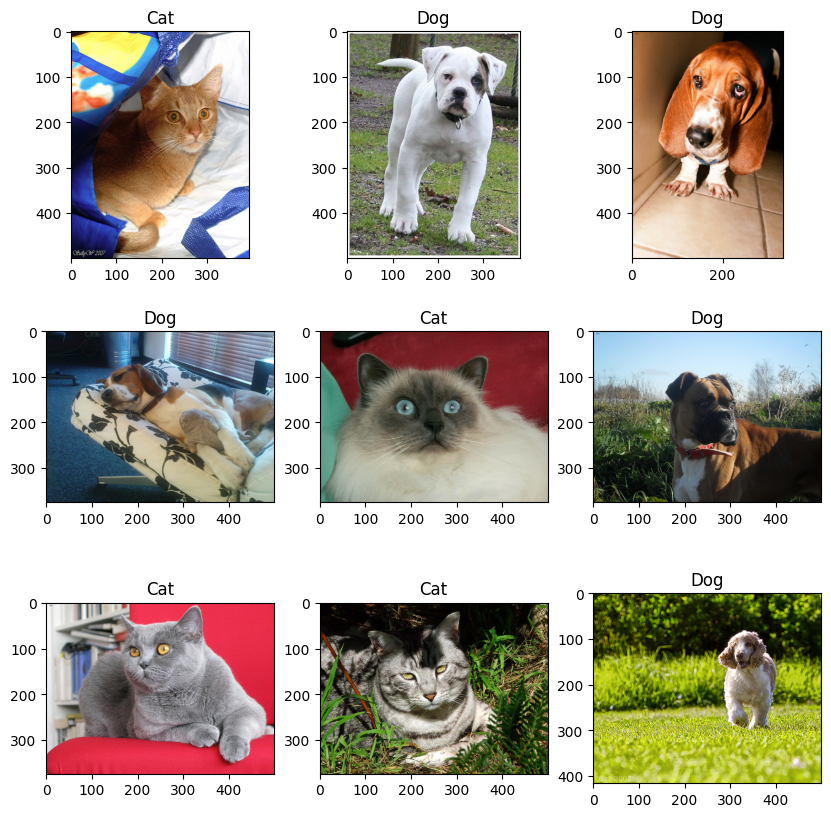

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img_plt
import numpy as np

def get_image(img_path):
    image = img_plt.imread(img_path)
    return image

fig = plt.figure(figsize=(10,10))
row,col = 3,3

for i in range(0,720,80):
    fig.add_subplot(row,col,int(i/80)+1)
    plt.imshow(get_image(images[i]))
    plt.title('Cat' if labels[i]==1 else 'Dog')

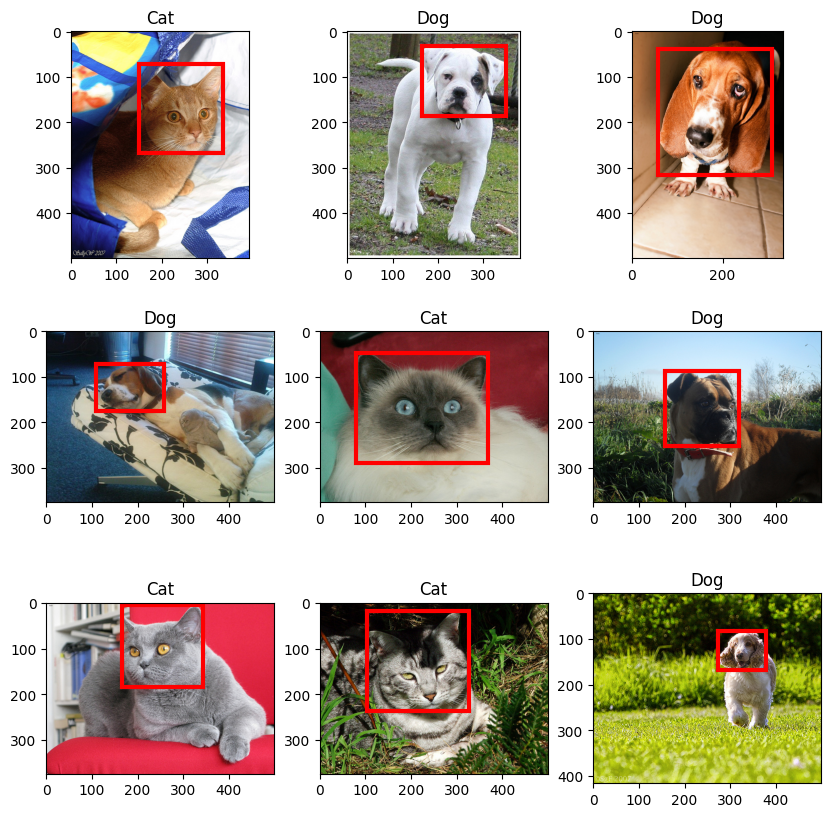

In [3]:
import matplotlib.patches as patches
bb_fig = plt.figure(figsize=(10,10))
for i in range(0, 720, 80):
    ax = bb_fig.add_subplot(row, col, int(i/80) + 1)
    ax.imshow(get_image(images[i]))
    x1, y1, x2, y2 = bboxes[i]
    # print(x1, y1, x2, y2)
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.set_title('Cat' if labels[i] == 1 else 'Dog')
plt.show()

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_with_padding(image, target_size):
    h, w, _ = image.shape
    target_h, target_w = target_size
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized_image = cv2.resize(image, (new_w, new_h))
    pad_w = target_w - new_w
    pad_h = target_h - new_h
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    padded_image = cv2.copyMakeBorder(
        resized_image, pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0]  # Padding with black color
    )

    return padded_image,(pad_left, pad_top, new_w, new_h)

def load_data(image_dir, annotation_dir, class_file):
    images = []
    bboxes = []
    labels = []
    target_size = (128, 128)
    with open(class_file, 'r') as f:
        for line in f:
            if line[0] != "#":
                parts = line.strip().split()
                image_name = parts[0] + '.jpg'
                class_id = int(parts[2])
                annotation_path = os.path.join(annotation_dir, parts[0] + '.xml')
                image_path = os.path.join(image_dir, image_name)
                if os.path.exists(image_path) and os.path.exists(annotation_path):
                    img = cv2.imread(image_path)
                    if img is not None:
                        img,padding_info = resize_with_padding(img,target_size)
                        pad_left, pad_top, new_w, new_h = padding_info
                        images.append(img)
                        labels.append(class_id - 1)
                        bbox = load_annotations(annotation_path)
                        bbox[0] = bbox[0] + pad_left*4
                        bbox[1] = bbox[1] + pad_top*4
                        bbox[2] = bbox[2] + pad_left*4
                        bbox[3] = bbox[3] + pad_top*4

                        # Normalize the bounding box coordinates
                        bbox = [bbox[0] / target_size[1], bbox[1] / target_size[0], bbox[2] / target_size[1], bbox[3] / target_size[0]]

                        bboxes.append(bbox)
    return np.array(images), np.array(labels), np.array(bboxes)

df_images, df_labels, df_bboxes = load_data(image_dir, annotation_dir, class_file)



In [5]:
print(df_images.shape)
print(df_labels.shape)
print(df_bboxes.shape)

(3671, 128, 128, 3)
(3671,)
(3671, 4)


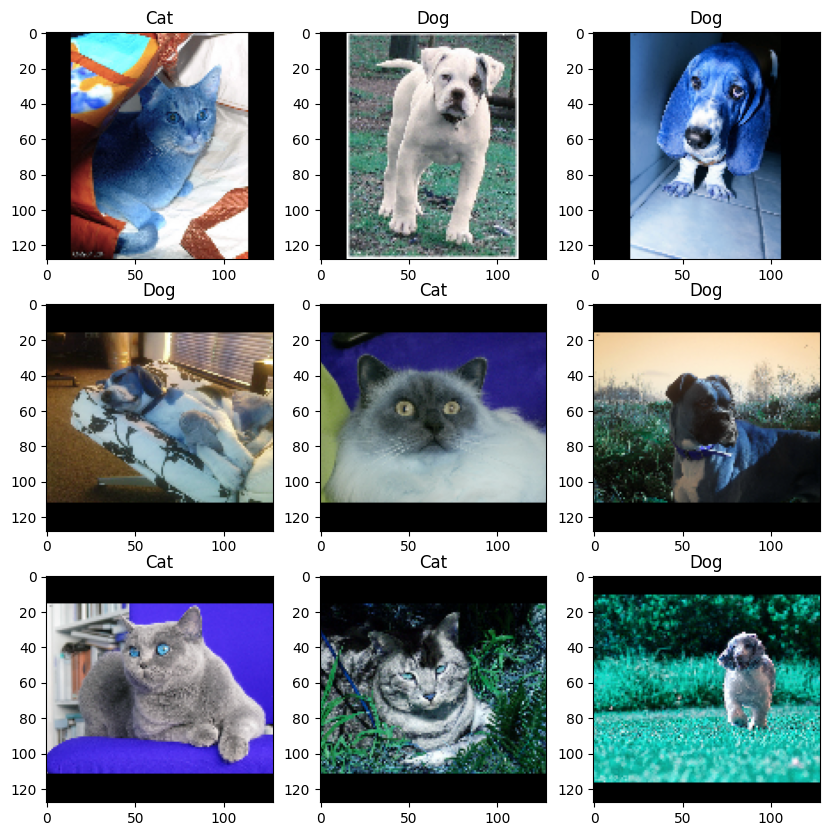

In [7]:
fig = plt.figure(figsize=(10,10))
row,col = 3,3
for i in range(0,720,80):
    fig.add_subplot(row,col,int(i/80)+1)
    plt.imshow(df_images[i])
    plt.title('Cat' if labels[i]==1 else 'Dog')

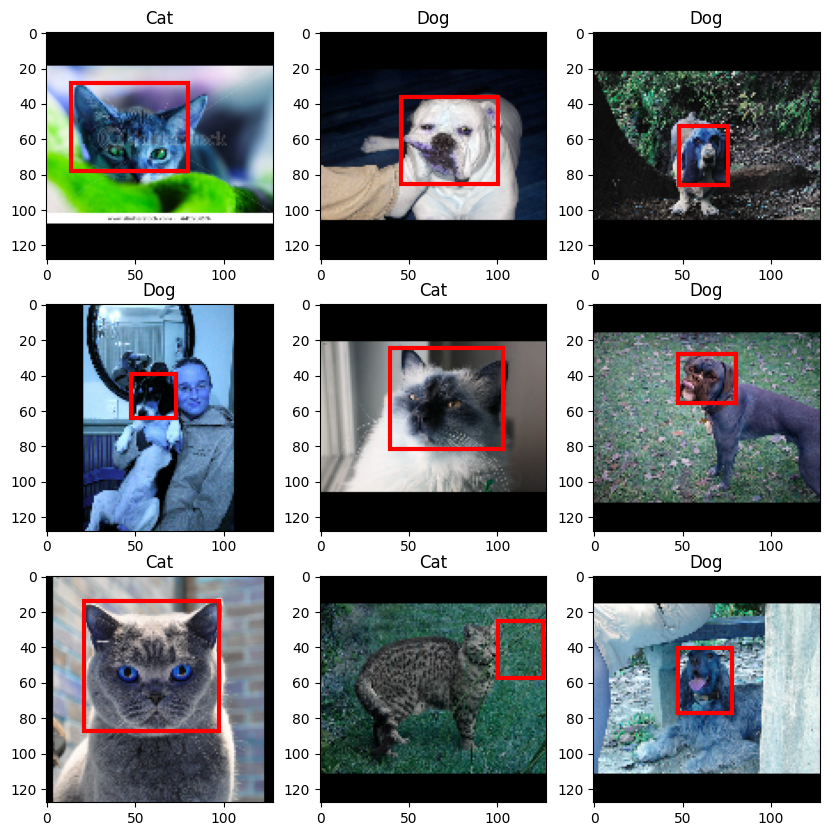

In [8]:
d_bb_fig = plt.figure(figsize=(10,10))
for i in range(0, 720, 80):
    ax = d_bb_fig.add_subplot(row, col, int(i/80) + 1)
    ax.imshow(df_images[i+1])
    x1, y1, x2, y2 = df_bboxes[i+1]*32
    # print(x1, y1, x2, y2)
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.set_title('Cat' if labels[i+1] == 1 else 'Dog')
plt.show()

In [136]:

print(df_images.shape)
X_train, X_val, y_train, y_val, bboxes_train, bboxes_val = train_test_split(
    df_images, df_labels, df_bboxes, test_size=0.2, random_state=42
)
X_train = X_train / 255.0
X_val = X_val / 255.0
if y_train.ndim == 2 and y_train.shape[1] == 2:
    y_train = np.argmax(y_train, axis=1)
    y_val = np.argmax(y_val, axis=1)

print(y_train)


(3671, 128, 128, 3)
[1 0 1 ... 1 0 0]


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (128, 128, 3)

def create_model(input_shape,optimizer='adam'):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    class_output = layers.Dense(1, activation='sigmoid', name='class_output')(x)
    
    bbox_output = layers.Dense(4, name='bbox_output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=[class_output, bbox_output])
    model.compile(optimizer=optimizer,
              loss={'class_output': 'binary_crossentropy', 'bbox_output': 'mean_squared_error'},
              metrics={'class_output': 'accuracy', 'bbox_output': 'mean_squared_error'})
    return model

model = create_model(input_shape)
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           36928     ['max_pooling2d[0][0]']

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
history = model.fit(
    X_train, 
    {'class_output': y_train, 'bbox_output': bboxes_train},
    validation_data=(X_val, {'class_output': y_val, 'bbox_output': bboxes_val}),
    epochs=25,
    batch_size=32,
    callbacks = [early_stopping]
)


Epoch 1/25


92/92 [==============================] - 67s 643ms/step - loss: 1.2044 - class_output_loss: 0.6444 - bbox_output_loss: 0.5600 - class_output_accuracy: 0.6723 - bbox_output_mean_squared_error: 0.5600 - val_loss: 1.1204 - val_class_output_loss: 0.6300 - val_bbox_output_loss: 0.4904 - val_class_output_accuracy: 0.6639 - val_bbox_output_mean_squared_error: 0.4904
Epoch 2/25
92/92 [==============================] - 57s 621ms/step - loss: 1.0169 - class_output_loss: 0.6187 - bbox_output_loss: 0.3982 - class_output_accuracy: 0.6846 - bbox_output_mean_squared_error: 0.3982 - val_loss: 1.0861 - val_class_output_loss: 0.6149 - val_bbox_output_loss: 0.4712 - val_class_output_accuracy: 0.6776 - val_bbox_output_mean_squared_error: 0.4712
Epoch 3/25
92/92 [==============================] - 57s 620ms/step - loss: 0.9890 - class_output_loss: 0.5973 - bbox_output_loss: 0.3917 - class_output_accuracy: 0.6897 - bbox_output_mean_squared_error: 0.3917 - val_loss: 1.0955 - val_class_output_loss

In [1]:
results = model.evaluate(X_val, {'class_output': y_val, 'bbox_output': bboxes_val})
print(f"Validation Loss: {results[0]}")
print(f"Validation Classification Accuracy: {results[1]}")
print(f"Validation Bounding Box MSE: {results[2]}")


23/23 [==============================] - 5s 196ms/step - loss: 0.9073 - class_output_loss: 0.4917 - bbox_output_loss: 0.4155 - class_output_accuracy: 0.7660 - bbox_output_mean_squared_error: 0.4155
Validation Loss: 0.72559475898743
Validation Classification Accuracy: 0.6917192757129669
Validation Bounding Box MSE: 0.41553664207458496


In [123]:
def plot_graph(train,val,lis):
    x_label,y_label,title = lis
    plt.plot(train, label='Train Loss')
    plt.plot(val, label='Validation Loss')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()


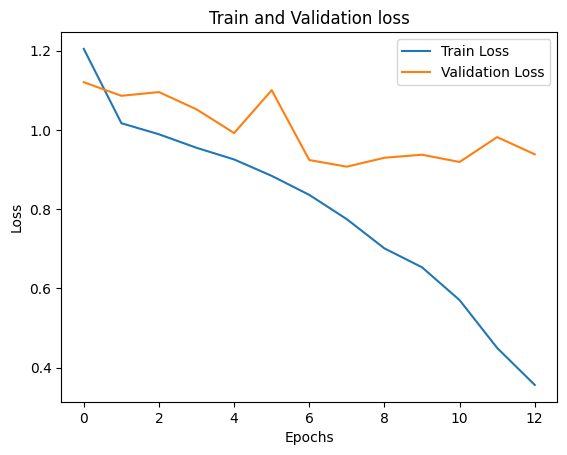

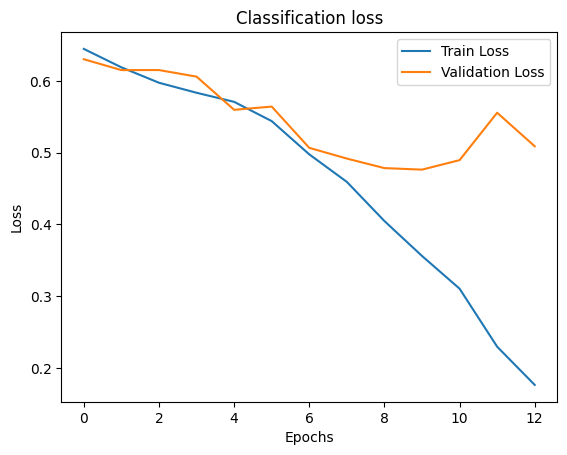

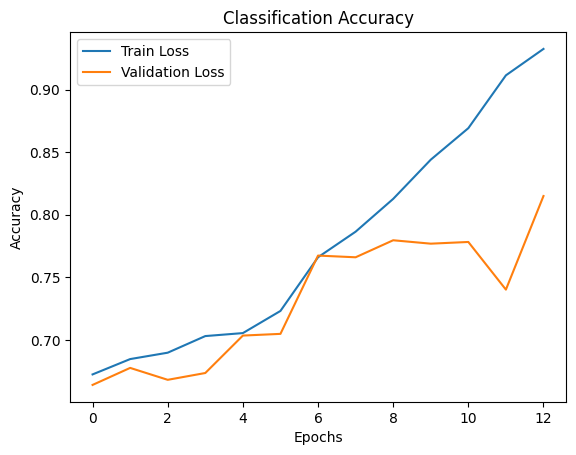

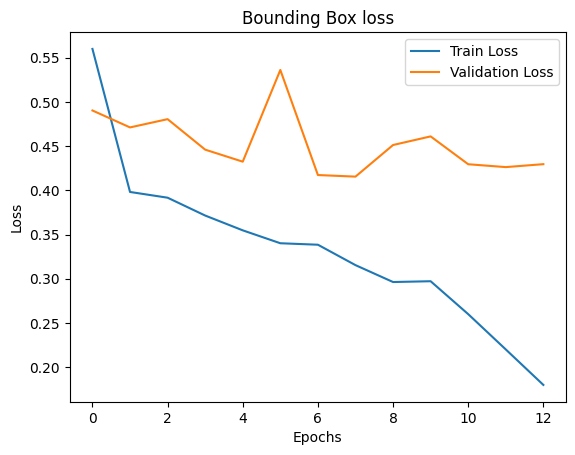

In [124]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_graph(train_loss,val_loss,['Epochs','Loss','Train and Validation loss'])

class_loss = history.history['class_output_loss']
val_class_loss = history.history['val_class_output_loss']
plot_graph(class_loss,val_class_loss,['Epochs','Loss','Classification loss'])

class_accuracy = history.history['class_output_accuracy']
val_class_accuracy = history.history['val_class_output_accuracy']
plot_graph(class_accuracy,val_class_accuracy,['Epochs','Accuracy','Classification Accuracy'])

bb_loss = history.history['bbox_output_mean_squared_error']
val_bb_loss = history.history['val_bbox_output_mean_squared_error']
plot_graph(bb_loss,val_bb_loss,['Epochs','Loss','Bounding Box loss'])




In [132]:
test_image_path = "C:/Users/Dell/Downloads/oxford-iiit-pet/images/images/english_cocker_spaniel_106.jpg"
test_image = cv2.imread(test_image_path)
test_image,test_image_info = resize_with_padding(test_image,(128,128))
test_image = test_image / 255.0
test_image = np.expand_dims(test_image, axis=0)
# img,padding_info = resize_with_padding(img,target_size)
print(test_image.shape)

(1, 128, 128, 3)


In [133]:
class_pred, bbox_pred = model.predict(test_image)
class_label = 'Dog' if class_pred[0][0] > 0.5 else 'Cat'
print(class_label)


1/1 [==============================] - 0s 180ms/step
Dog


In [134]:
def draw_bbox(image_path, bbox,bbox_predt,img_info):
    left = img_info[0]
    top = img_info[1]
    fig,ax = plt.subplots()
    ax.imshow(test_image[0])
    x1,y1,x2,y2 = bbox
    x1,y1,x2,y2 = x1+left,y1+top,x2+left,y2+top
    width = x2-x1
    height = y2-y1
    xmin,ymin,xmax,ymax = bbox_predt*32
    pred_width = x2-x1
    pred_height = y2-y1
    rect = patches.Rectangle((x1,y1),width,height,linewidth = 2,edgecolor='r',facecolor= 'none',label = 'Actual Bounding Box')
    pred_rect = patches.Rectangle((xmin,ymin),pred_width,pred_height,linewidth = 2,edgecolor='g',facecolor= 'none',label = 'Predicted Bounding Box')
    ax.add_patch(rect)
    ax.add_patch(pred_rect)
    plt.legend()
    plt.show()

print(bbox_pred[0]*128)

[181.15611 136.74052 317.01718 290.57303]


[174, 10, 331, 161]
[43.5, 2.5, 82.75, 40.25]


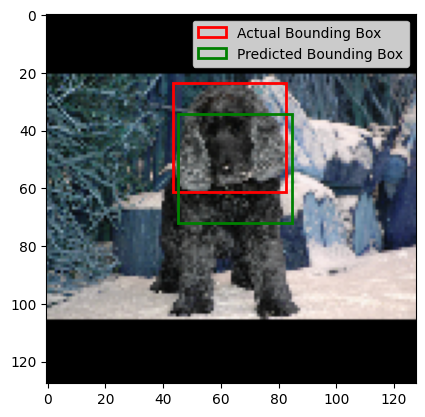

In [135]:
act_bbox = load_annotations('C:/Users/Dell/Downloads/oxford-iiit-pet/annotations/annotations/xmls/english_cocker_spaniel_106.xml')
print(act_bbox)
#Normalizing the actual values as the image is resized
act_bbox[0]=(act_bbox[0]/128)*32
act_bbox[1]=(act_bbox[1]/128)*32
act_bbox[2]=(act_bbox[2]/128)*32
act_bbox[3]=(act_bbox[3]/128)*32
print(act_bbox)

draw_bbox(test_image[0],act_bbox,bbox_pred[0],test_image_info)